# Auditing a CNN trained on CIFAR100 using the Reference Attack

## Introduction

In this tutorial, we will see:

- How to specify the dataset and model for Privacy Meter
- How to audit a Tensorflow model
- How to use the `ReferenceMetric` to evaluate membership leakage using loss values from reference models
- How to visualize the audit result

## Imports

In [1]:
import numpy as np
import tensorflow as tf

In [17]:
from privacy_meter.audit import Audit
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.hypothesis_test import linear_itp_threshold_func
from privacy_meter.information_source import InformationSource
from privacy_meter.metric import ReferenceMetric
from privacy_meter.model import TensorflowModel
from privacy_meter.information_source_signal import ModelLoss

## Settings

Setting seed for reproducibility:

In [3]:
seed = 1234
np.random.seed(seed)
rng = np.random.default_rng(seed=seed)

Hyperparameters:

In [4]:
# for training the target and reference models
num_points_per_train_split = 5000
num_points_per_test_split = 1000
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optim_fn = 'adam'
epochs = 10
batch_size = 64
regularizer_penalty = 0.01
regularizer = tf.keras.regularizers.l2(l=regularizer_penalty)

In [5]:
# for the reference metric
num_reference_models = 10
fpr_tolerance_list = [
    0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
]

## Dataset creation

We use the CIFAR100 dataset for this tutorial. As Tensorflow already has the data loading code for CIFAR100, we just need to add our pre-processing code on top of it.

In [6]:
def preprocess_cifar100_dataset():
    input_shape, num_classes = (32, 32, 3), 100

    # split the data between train and test sets
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

    # scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # convert labels into one hot vectors
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    return x_train, y_train, x_test, y_test, input_shape, num_classes

x_train_all, y_train_all, x_test_all, y_test_all, input_shape, num_classes = preprocess_cifar100_dataset()

In [7]:
print(x_train_all.shape, x_test_all.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


CIFAR100 comes with the predetermined train and test partitions. We further split the train partition into more sets - 'train' and 'reference' for the audit. 

We will have the following sets at the end of this partitioning:

- The 'train' set will be used to train the target model. It will be used as the 'member' set for the audit.
- The 'test' set will be used as the 'non-member' set for the audit.
- The 'reference' set will be used later as the pool of data to train the reference models.

We wrap the sets into a `Dataset` object, which takes in the following arguments:

- `data_dict` contains the actual dataset, in the form of a 2D dictionary. The first key corresponds to the split name (here we have two: "train" and "test"), and the second key to the feature name (here we also have two: "x" and "y").
- `default_input` contains the name of the feature that should be used as the models input (here "x").
- `default_output` contains the name of the feature that should be used as the label / models output (here "y").

In [8]:
# create the target model's dataset
dataset = Dataset(
    data_dict={
        'train': {'x': x_train_all, 'y': y_train_all},
        'test': {'x': x_test_all, 'y': y_test_all}
    },
    default_input='x',
    default_output='y'
)

Finally, we use the built-in `Dataset.subdivide()` function, to split the two splits ("train" and "test") into multiple sub-datasets (one per model). The resulting sub-splits are included in the parent object ("train000", "train001", etc.) and are returned as a list of individual Dataset objects.

In [9]:
datasets_list = dataset.subdivide(
    num_splits=num_reference_models + 1,
    delete_original=True,
    in_place=False,
    return_results=True,
    method='hybrid',
    split_size={'train': num_points_per_train_split, 'test': num_points_per_test_split}
)

In [10]:
for i, d in enumerate(datasets_list):
    print(i)
    print(d)

0
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
1
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
2
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
3
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
4
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
5
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x', 'y']
Default features  = x --> y
6
================ DATASET OBJECT ================
Splits            = ['train', 'test']
Features          = ['x

## Training the target and reference models

We define the Tensorflow model to be used as the target and reference models:

In [11]:
def get_tensorflow_cnn_classifier(input_shape, num_classes, regularizer):
    # TODO: change model architecture
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                                     input_shape=input_shape, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu',
                                     kernel_regularizer=regularizer))
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

And we compile and train the target model using the target dataset we defined above:

In [12]:
x = datasets_list[0].get_feature('train', '<default_input>')
y = datasets_list[0].get_feature('train', '<default_output>')
model = get_tensorflow_cnn_classifier(input_shape, num_classes, regularizer)
model.summary()
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               2

We wrap the target model in the `TensorflowModel` object:

In [13]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)

We will now train reference models using the respective datasets that have been constructed for the models, and wrap each one in a `TensorflowModel` object:

In [14]:
reference_models = []
for model_idx in range(num_reference_models):
    print(f"Training reference model {model_idx}...")
    reference_model = get_tensorflow_cnn_classifier(input_shape, num_classes, regularizer)
    reference_model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
    reference_model.fit(
        datasets_list[model_idx + 1].get_feature('train', '<default_input>'),
        datasets_list[model_idx + 1].get_feature('train', '<default_output>'),
        batch_size=batch_size,
        epochs=epochs,
        verbose=2
    )
    reference_models.append(
        TensorflowModel(model_obj=reference_model, loss_fn=loss_fn)
    )

Training reference model 0...
Train on 5000 samples
Epoch 1/10
5000/5000 - 6s - loss: 4.7611 - accuracy: 0.0230
Epoch 2/10
5000/5000 - 4s - loss: 4.3451 - accuracy: 0.0566
Epoch 3/10
5000/5000 - 5s - loss: 4.0748 - accuracy: 0.1080
Epoch 4/10
5000/5000 - 5s - loss: 3.8145 - accuracy: 0.1470
Epoch 5/10
5000/5000 - 5s - loss: 3.6468 - accuracy: 0.1802
Epoch 6/10
5000/5000 - 5s - loss: 3.4976 - accuracy: 0.2062
Epoch 7/10
5000/5000 - 5s - loss: 3.3788 - accuracy: 0.2310
Epoch 8/10
5000/5000 - 5s - loss: 3.2505 - accuracy: 0.2636
Epoch 9/10
5000/5000 - 5s - loss: 3.1680 - accuracy: 0.2692
Epoch 10/10
5000/5000 - 5s - loss: 3.0549 - accuracy: 0.3014
Training reference model 1...
Train on 5000 samples
Epoch 1/10
5000/5000 - 5s - loss: 4.7522 - accuracy: 0.0234
Epoch 2/10
5000/5000 - 4s - loss: 4.3331 - accuracy: 0.0518
Epoch 3/10
5000/5000 - 4s - loss: 4.0574 - accuracy: 0.1050
Epoch 4/10
5000/5000 - 5s - loss: 3.8488 - accuracy: 0.1446
Epoch 5/10
5000/5000 - 4s - loss: 3.6797 - accuracy: 0.

## Information Sources

We can now define two `InformationSource` objects. Basically, an information source is an abstraction representing a set of models, and their corresponding dataset. Note that for the `ReferenceMetric` we use the same dataset in both the target and reference information sources, but the models that will be used for querying the dataset will differ.

In [15]:
target_info_source = InformationSource(
    models=[target_model],
    datasets=[datasets_list[0]]
)

reference_info_source = InformationSource(
    models=reference_models,
    datasets=[datasets_list[0]] # we use the same dataset for the reference models
)

## Metric and Audit

We now create a `Metric` object, which is an abstraction representing an algorithm used to measure something on an `InformationSource`, such as membership information leakage. In this case, we use the `ReferenceMetric` to measure the membership information leakage of `target_info_source` in a black-box setting, using loss values returned by the reference model on the target dataset in `reference_info_source`.

The `Audit` object is a wrapper to actually run the audit, and display the results. More visualization options will be added soon.

In [18]:
reference_metric = ReferenceMetric(
    target_info_source=target_info_source,
    reference_info_source=reference_info_source,
    signals=[ModelLoss()],
    hypothesis_test_func=linear_itp_threshold_func,
    logs_dirname='tutorial_reference_metric'
)

In [19]:
audit_obj = Audit(
    metrics=[reference_metric],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=[target_info_source],
    reference_info_sources=[reference_info_source],
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()

In [20]:
audit_results = audit_obj.run()[0]
for result in audit_results:
    print(result)

Results are stored in: ['/Users/aadyaamaddi/Desktop/ML Privacy Meter/privacy_meter/docs/log_2022-06-13_16-39-04-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.16666666666666666
ROC AUC Score     = 0.5
FPR               = 0.0
TN, FP, FN, TP    = (1000, 0, 5000, 0)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5283333333333333
ROC AUC Score     = 0.6518
FPR               = 0.163
TN, FP, FN, TP    = (837, 163, 2667, 2333)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.61
ROC AUC Score     = 0.664
FPR               = 0.255
TN, FP, FN, TP    = (745, 255, 2085, 2915)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.6703333333333333
ROC AUC Score     = 0.663
FPR               = 0.348
TN, FP, FN, TP    = (652, 348, 1630, 3370)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.717
ROC AUC Score     = 0.655
FPR               = 0.438
TN, FP, FN, TP    = (562, 438, 1260, 3740)


## Result visualization

Several visualization tools are built in `privacy_tool`, such as ROC curves, signal values histogram, or confusion matrix.

In [21]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

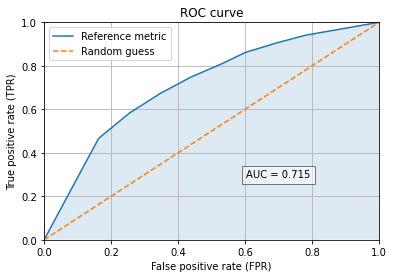

<Figure size 432x288 with 0 Axes>

In [22]:
ROCCurveReport.generate_report(
    metric_result=audit_results,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

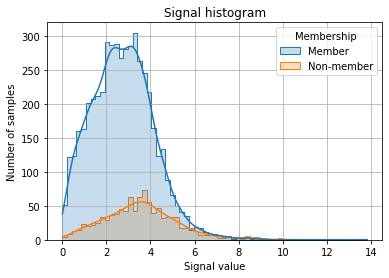

<Figure size 432x288 with 0 Axes>

In [23]:
SignalHistogramReport.generate_report(
    metric_result=result,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)